# Artificial Neural Networks and Deep Learning

---

## Homework 1: EfficientNetV0B2 75%


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/DeepL Team/Matteo

Mounted at /gdrive
/gdrive/My Drive/DeepL Team/Michele


## ⚙️ Import Libraries

## ⏳ Load the Data

In [ ]:
data_train=np.load('../data_augmented.npz')
data_val=np.load("../data_validation.npz")
images_train=data_train["images"]
labels_train=data_train["labels"]
images_val=data_val["images"]
labels_val=data_val["labels"]
images_val, images_test, labels_val, labels_test = train_test_split(
    images_val,
    labels_val,
    test_size=459,
    random_state=seed,
    stratify=labels_val
)
del data_train
del data_val


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Flatten, Dropout, Dense
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# extra libraries:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.17.0


#Preprocessing

In [ ]:
print(images_train.shape)
print(labels_train.shape)
print(images_val.shape)
print(labels_val.shape)
print(images_test.shape)
print(labels_test.shape)

input_shape = images_train.shape[1:]
print(f'Input shape of the network {input_shape}')

output_shape = labels_train.shape[1]
print(f'Output shape of the network {output_shape}')

(16000, 96, 96, 3)
(16000, 8)
(1500, 96, 96, 3)
(1500, 8)
(459, 96, 96, 3)
(459, 8)
Input shape of the network (96, 96, 3)
Output shape of the network 8


## 🛠️ Train and Save the Model

In [ ]:
# Load EfficientNetB0 without the top classification layers
base_model = EfficientNetV2B0(
    include_top=False,  # Exclude the top Dense layers
    weights='imagenet',  # Use pretrained weights
    input_shape=(96, 96, 3),  # Input shape
    pooling='avg'  # Use global average pooling
)

# Freeze the base model for feature extraction
base_model.trainable = False

# Define input layer
inputs = Input(shape=(96, 96, 3), name='input_layer')

# EfficientNetV2 preprocessing (automatically applied by the EfficientNetV2 layer)
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)


# Pass the inputs through EfficientNetB0
x = base_model(x)

# Add a dense layer for feature transformation
x = Dense(units=256, name='dense1')(x)
x = BatchNormalization(name='batchnorm1')(x)
x = Activation('relu', name='HiddenActivation1')(x)
x = Dropout(0.3, name='dropout')(x)

# Add the final classification layer
outputs = Dense(labels_train.shape[-1], activation='softmax', name='output_layer')(x)

# Define the complete model
model = Model(inputs=inputs, outputs=outputs, name='EffNetB0_model')

# Compile the model
model.compile(
    loss=CategoricalCrossentropy(),  # Loss function for multi-class classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with learning rate
    metrics=['accuracy']
)

# Display the model summary
model.summary(expand_nested=True)



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNetB0_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_activation       │ (None, 24, 24, 64)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_project_conv (Conv2D)   │ (None, 24, 24, 32)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_project_bn              │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2b_expand_conv (Conv2D)    │ (None, 24, 24, 128)         │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2b_expand_bn               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,250,328 (23.84 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

In [ ]:
# Train the model
history = model.fit(
    x=images_train,
    y=labels_train,
    batch_size=50,
    epochs=200,
    validation_data=(images_val, labels_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = '9_TL.keras'
model.save(model_filename)

print(model.evaluate(images_test, labels_test))

# Free memory by deleting the model instance
del model

Epoch 1/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.2818 - loss: 2.0077 - val_accuracy: 0.6673 - val_loss: 1.0013
Epoch 2/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5120 - loss: 1.3388 - val_accuracy: 0.7453 - val_loss: 0.7970
Epoch 3/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5823 - loss: 1.1717 - val_accuracy: 0.7740 - val_loss: 0.7040
Epoch 4/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5997 - loss: 1.0949 - val_accuracy: 0.7953 - val_loss: 0.6502
Epoch 5/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6290 - loss: 1.0230 - val_accuracy: 0.8133 - val_loss: 0.6178
Epoch 6/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6513 - loss: 0.9719 - val_accuracy: 0.8133 - val_loss: 0.5917
Epoch 7/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6612 - loss: 0.9312 - val_accuracy: 0.8160 - val_loss: 0.5793
Epoch 8/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6785 - loss: 0.8978 

Final validation accuracy: 83.6%


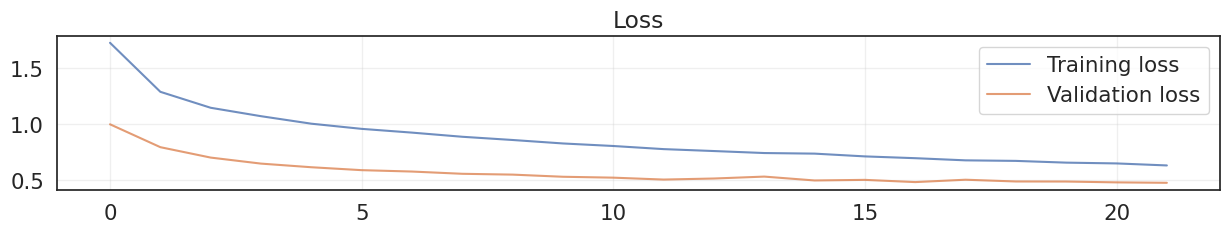

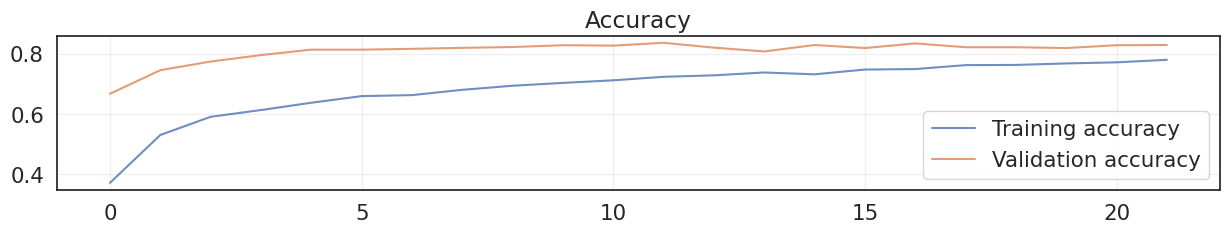

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('9_TL.keras')

# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('efficientnetv2-b0').trainable = True

# Set the number of layers to freeze
N = 7
for layer in ft_model.get_layer('efficientnetv2-b0').layers[:N]:  # Freeze all but the last 50 layers for more flexibility
  layer.trainable = False

'''
# Fine-tune by unfreezing some layers of EfficientNetV2B0
efficientnetv2-b0.trainable = True
for layer in efficientnet_v2b0.layers[:-30]:  # Keep earlier layers frozen
    layer.trainable = False
'''

# Re-compile the model with a lower learning rate for fine-tuning
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(0.00001), metrics=['accuracy'])

# Fine-tune the model
ft_history = ft_model.fit(
    x = images_train,
    y = labels_train,
    batch_size = 50,
    epochs = 200,
    validation_data = (images_val, labels_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history


Epoch 1/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 98s 54ms/step - accuracy: 0.4153 - loss: 1.7500 - val_accuracy: 0.8193 - val_loss: 0.4999
Epoch 2/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.7167 - loss: 0.7814 - val_accuracy: 0.9007 - val_loss: 0.2723
Epoch 3/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8340 - loss: 0.4741 - val_accuracy: 0.9320 - val_loss: 0.2092
Epoch 4/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9049 - loss: 0.2883 - val_accuracy: 0.9400 - val_loss: 0.1776
Epoch 5/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9464 - loss: 0.1734 - val_accuracy: 0.9407 - val_loss: 0.1816
Epoch 6/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9703 - loss: 0.1075 - val_accuracy: 0.9580 - val_loss: 0.1593
Epoch 7/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9802 - loss: 0.0729 - val_accuracy: 0.9580 - val_loss: 0.1677
Epoch 8/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9852 - loss: 0.05

## Evaluation and plot of the model

Final validation accuracy: 97.33%
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9634 - loss: 0.1339
[0.12854930758476257, 0.9673202633857727]


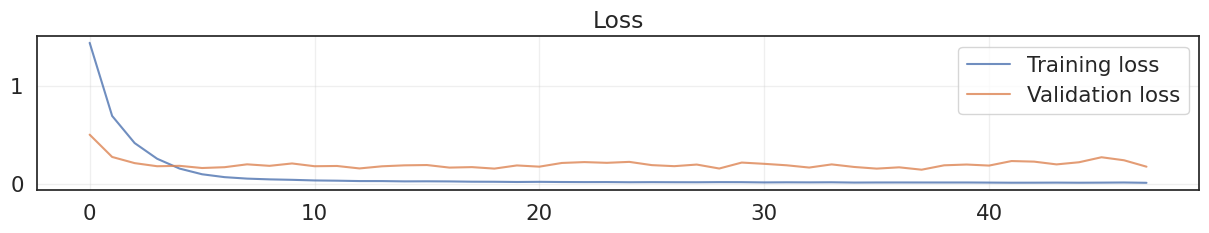

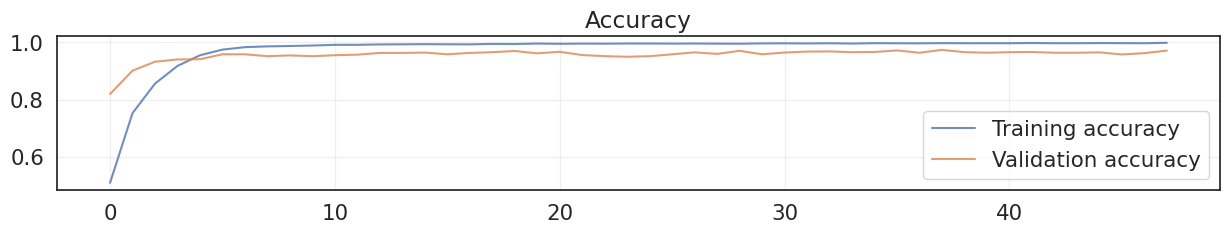

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = '10_FT.keras'
ft_model.save(model_filename)

print(ft_model.evaluate(images_test, labels_test))
'''
#model = tl_model
# Calculate and print the final validation accuracy
#history = history_fine_tune
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'EffNetV2B0'+str(final_val_accuracy)+'.keras'
model.save(model_filename)
print(model_filename)

# Delete the model to free up resources
del model
'''
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(ft_history['loss'], label='Training loss', alpha=.8)
plt.plot(ft_history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(ft_history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(ft_history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
print(model_filename)

8_TL.keras


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('10_FT.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        if X.max() < 2:
            X = (X * 255.0).astype('float32')  # Normalize to the range [0, 1]

        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py 10_FT.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 54%)
  adding: 10_FT.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tfk.models.load_model("EffNetB075.keras")

<Sequential name=sequential_3, built=True>

In [ ]:
from tensorflow.keras import Input

dummy_input = Input(shape=input_shape)
output = efficientnet_b0(dummy_input)
print(type(output))
print(output.shape)


<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
(None, 1280)


In [ ]:
print(type(images_train), type(labels_train))
print(images_train.shape, labels_train.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(16000, 96, 96, 3) (16000, 8)
